---
# Model S - Baseline Model with Stochastic Gradient Descent (SGD) Optimizer
- **32 x 32 x 3** Image size.
- **64** Batch size.
- Stochastic Gradient Descent **(SGD)** optimizer with **0.8** momentum.
- **0.01** Initial Learning rate.
- **Sparse Categorical Cross-Entropy** loss function.
- **Reduce Learning Rate on Plateau** callback with a **0.1** factor and **3** patience.
- **Early Stopping** callback with **6** patience.
- **Model Checkpoint** callback to save the best model based on validation loss.
- 3 **Convolutional** layers with **32**, **64** and **128** filters, with **ReLU** activation.
- 3 **MaxPooling** layers with **2 x 2** pool size.
- **3 x 3** Convolutional kernel size.
- **Padding** is **valid**.
- **4 x 4 x 128** Tensor before Global Max Pooling.
- Global **MaxPooling** layer instead of **Flatten**.
- **64** Dense layer with **ReLU** activation.
- **10** Dense output layer with **Softmax** activation.
- **102 154** Trainable Parameters
- **30** Epochs.

---
#### Imports and Setup

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [21]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

---
#### Create Datasets

In [22]:
IMG_SIZE = 32
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 32, 32, 3)
labels batch shape: (64,)


- We define the image size of 32 x 32 x 3, batch size of 64 and create an array with the label's names.
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Model Architecture

In [23]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                      

---
#### Model Compilation

In [24]:
initial_learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.8)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/01_model_s_baseline_sgd.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

---
#### Model Training

In [25]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
626/628 [============================>.] - ETA: 0s - loss: 2.0710 - accuracy: 0.2391
Epoch 1: val_loss improved from inf to 1.84341, saving model to ../models/01_model_s_baseline_sgd.keras
628/628 [==============================] - 13s 20ms/step - loss: 2.0704 - accuracy: 0.2394 - val_loss: 1.8434 - val_accuracy: 0.3392 - lr: 0.0100
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 1.6561 - accuracy: 0.4024
Epoch 2: val_loss improved from 1.84341 to 1.51398, saving model to ../models/01_model_s_baseline_sgd.keras
628/628 [==============================] - 13s 21ms/step - loss: 1.6561 - accuracy: 0.4024 - val_loss: 1.5140 - val_accuracy: 0.4483 - lr: 0.0100
Epoch 3/30
626/628 [============================>.] - ETA: 0s - loss: 1.4715 - accuracy: 0.4685
Epoch 3: val_loss improved from 1.51398 to 1.39722, saving model to ../models/01_model_s_baseline_sgd.keras
628/628 [==============================] - 13s 20ms/step - loss: 1.4717 - accuracy: 0.4685 - val_los

---
#### Save Model History

In [26]:
with open("../history/01_model_s_baseline_sgd.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [27]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Model Validation Loss: {val_loss:.2f}')
print(f'Model Validation Accuracy: {val_acc:.2%}')

157/157 [==============================] - 1s 6ms/step - loss: 0.8680 - accuracy: 0.7079
Model Validation Loss: 0.87
Model Validation Accuracy: 70.79%


---
#### Model Training Visualization

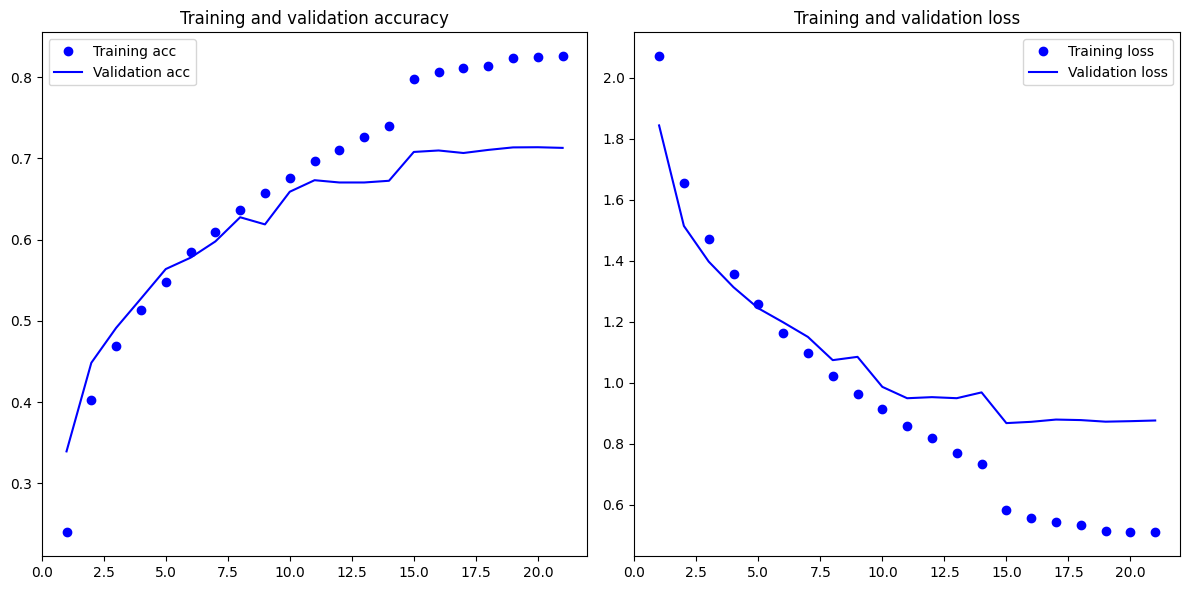

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting after the **7th** epoch.
    - The training accuracy stops improving significantly after the **12th** epoch while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **12th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **12th** epoch.
    - The training stops after the **18th** epoch because of the **Early Stopping** callback.

---
#### Model Testing

In [29]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 59ms/step


---
#### Confusion Matrix

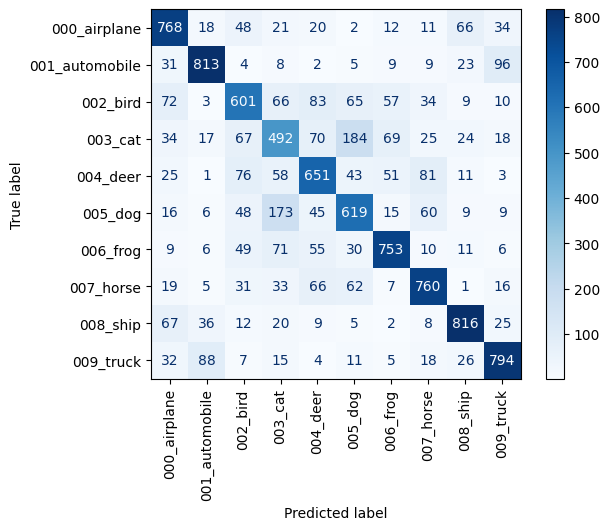

In [30]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model has a hard time distinguishing the categories 003_cat and 005_dog.  
    - The model has a below average performance on the categories 003_cat, 005_dog, 002_bird and 004_deer, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the error is not as significant.  
    - The model has an above average performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.

---
#### ROC Curve Analysis

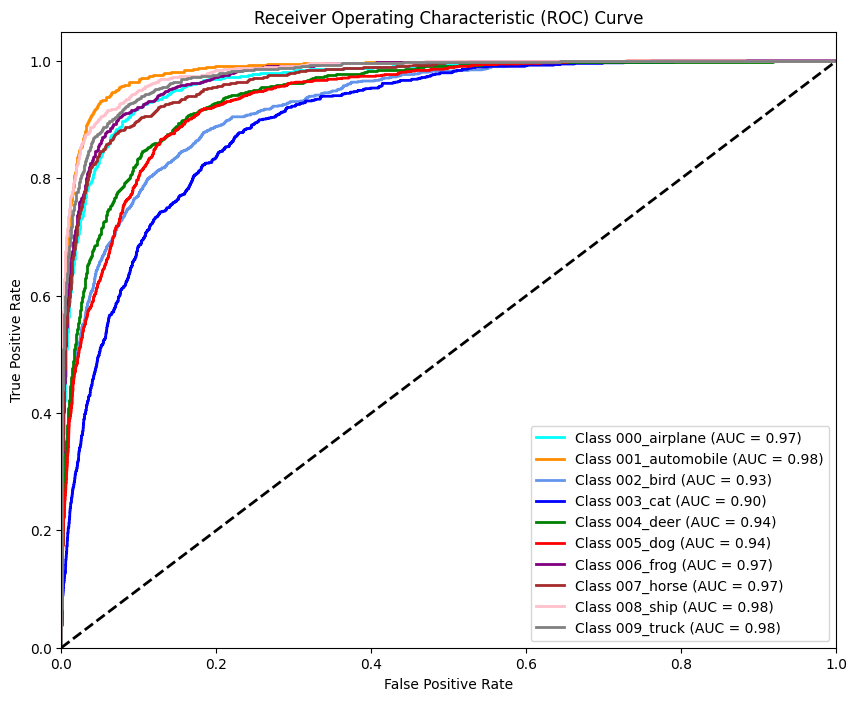

In [31]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a mediocre performance on the ROC curve for most categories.  
    - The categories 003_cat, 002_bird, 005_dog and 004_deer have the worst AUC (Area Under Curve) performance.
    - The categories 001_automobile, 006_frog, 008_ship and 009_truck have the best AUC performance.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [32]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 70.67%
Precision - Macro: 70.58%
Recall - Macro: 70.67%
F1-score - Macro: 70.61%
Precision - Weighted: 70.58%
Recall - Weighted: 70.67%
F1-score - Weighted: 70.61%


- **Since the dataset is balanced, the **MACRO** average is a good metric to evaluate the model.**

# Conclusion
### Summary
- In this notebook:
    - We trained a model with minimal complexity to serve as a **baseline** for future improvements.
    - Overfitting was observed after **7 epochs**, but the best model was saved at the **12th epoch**.
    - Training was intended for 30 epochs but stopped early due to the **Early Stopping** callback.
    - We evaluated the model using a confusion matrix to analyze its performance on each category.
    - We evaluated the model using ROC curves for a deeper performance analysis.
    - The model achieved an accuracy of **68.15%%** on the test set.
    - The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
    - The model showed a below average performance on the categories cats, dogs, birds and deer.
    - The model showed an above average performance on the categories automobile, frog, ship and truck.

### Future Work
- In the next notebook:
    - We will deepen, widen and enhance the architecture by:
        - We will add 2 more convolutional layers.
        - We will use a 512 unit dense layer.
        - We will add batch normalization after each convolution.
        - We will add dropout before each dense layer.
    - We will use the Adaptive Moment Estimation (Adam) optimizer.
    - We will keep the same 30 epochs.